In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder


## Prerequisites

- Perceptron
- Training flow
    - what is a loss function?
    - how to update a network
    - Intuition on how a ML model learns iteratively

# Concepts

- Model,pipeline: Forward prop, activation, loss, backward prop
- Layers
    - Hidden layers
    - Activation functions
- Loss functions
    - Types, uses, pros and cons
- Optimizers


# Utils

In [ ]:
def initialize_weights(input_size, output_size):
    return np.random.uniform(-1, 1, (input_size, output_size))# + np.sqrt(2 / input_size)

def get_batches(x, batch_size = 64):
    return [x[i: i+ batch_size] for i in range(0, len(x), batch_size)]

def accuracy(y_real, y_pred):
    return np.sum(y_real == y_pred) / len(y_real)

def shuffle(X, y):
    idxs = np.random.permutation(len(X))
    return X[idxs], y[idxs]

# Neural Net

- https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html - must read
- https://github.com/calinbiberea/neural_networks/blob/master/part1_nn_lib.py - yoinked the implementations from here

## From Perceptron to NN

**Perceptron**
- Linear classifiers
- Model: $h(x) = w^Tx + b$

**Kernel functions**
- https://en.wikipedia.org/wiki/Kernel_method
- Model $x \mapsto \phi(x) \Rightarrow h(x) = w^T\phi(x)$

**Neural network**
- Model: $h(x) = w^T\phi(x) + b$
- $\phi(x) = \sigma(Ax + c)$
- $\sigma$ = some non-linear function (sigmoid, relu etc)
- without $\sigma$ = $h$ is a linear classifier $\to w^T\phi(x) = w^T(Ax + c) = \underbrace{w^TA}_{\hat{w} }x + \underbrace{w^Tc}_{\hat{b}}$

**Kernels vs NN**
- Kernels scale quadratic or you do approximations => you lose accuracy
- NN scale linearly with data

## Forward propagation

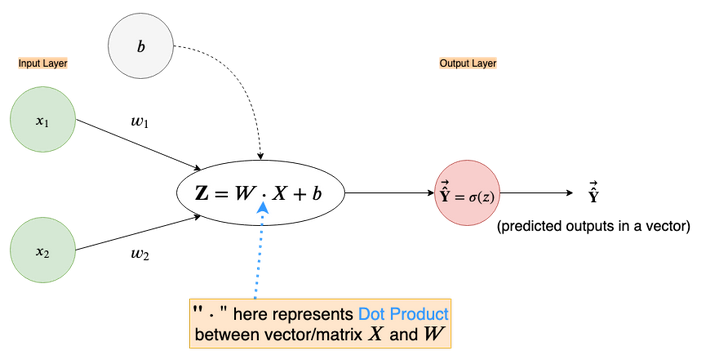

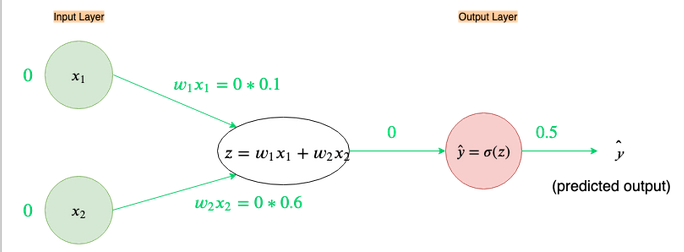

## Loss functions

$$loss = \sum_{i=1}^n l(\underbrace{h(x_i)}_{\text{prediction}}, \underbrace{y_i}_{\text{real}})$$

### Regression 

When we evaluate a linear regression we want to look to minimize some error. *But what errors can we minimize?*

Let
- $N$ = number of datapoints
- $y_i$ = real output
- $h(x_i)$ = predicted output

#### MAE - Mean absolute error

Average the errors. $MAE \in \mathbb{R}$

$$MAE = \dfrac 1 N \sum_{i=1}^N |y_i - h(x_i)|$$



#### MSE

Square the errors then average them. $MSE \in \mathbb{R}$

$$MSE = \dfrac 1 N \sum_{i=1}^N (y_i - h(x_i))^2$$

#### MAE vs MSE

Since $MSE$ squares the errors it means big errors get bigger => outliers bring $MSE$ up => Sensible to outliers
- $\pm$ Optimizing by $MSE$ takes outliers more into consideration.
- $+$ Easily differentiable

$MAE$ is more robust when it comes to outliers. It is not suitable for applications where you want to pay more attention to the outliers

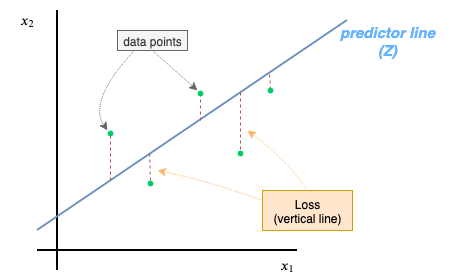

The derivative(gradient) of the loss function dictates **how much** to update the weights
- The steeper the slope => the more incorrect the prediction was


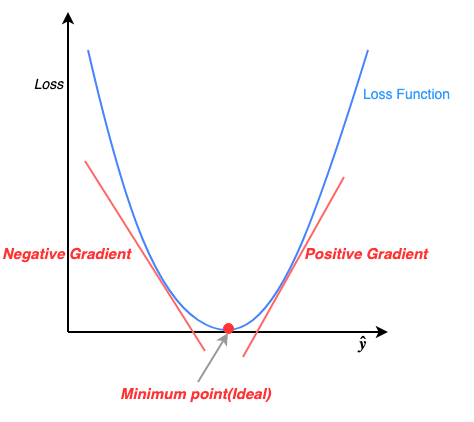

In [ ]:
def mse(y_real, y_pred, derivative = False):
    if derivative:
        return np.sum(2 * (y_pred - y_real) / len(y_pred))
    # **2 is elementwise for np.array
    return np.sum((y_real - y_pred) ** 2) / len(y_real)

### Classification 

#### Cross entropy
**Binary cross entropy**
- $-y\log(p) + (1-y) \log(1-p)$

**Multiclass cross entropy**
- $-\sum_{c=1}^M y_{o, c} \log(p_{o, c})$

where 

- $M$ - number of classes (dog, cat, fish)
- $\log$ - the natural log
- $y$ - binary indicator (0 or 1) if class label $c$ is the correct classification for observation $o$
- $p$ - predicted probability observation $o$ is of class $c$

In [ ]:
# https://stackoverflow.com/questions/36279904/softmax-derivative-in-numpy-approaches-0-implementation

def softmax(x, derivative = False):
    e_x  = np.exp(x - x.max(axis = 1, keepdims=True))
    res = e_x / e_x.sum(axis = 1, keepdims= True)
    if derivative == True:
        J = - res[..., None] * res[:, None, :]
        iy, ix = np.diag_indices_from(J[0])
        J[:, iy, ix] = res * (1. - res)
        #print(J, J.shape)
        return J
    
    return res

In [ ]:
def cross_entropy_loss(y_real, y_pred, derivative = False):
    n_obs = len(y_real)
    probs = softmax(y_pred)
    
    if derivative:
        return -1 / n_obs * (y_real - probs)
    
    return -1 / n_obs * np.sum(y_real * np.log(probs+ .000001))

## Backpropagation

- https://www.youtube.com/watch?v=XE3krf3CQls&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=23 - Best intuition I found


**Update step**
- We want to take a step in the right direction so we do
- $w = w - \alpha \cdot \dfrac {\partial L} {\partial w}$
- $b = b - \alpha \cdot \dfrac {\partial L} {\partial b}$
- Where $\alpha$ = learning rate

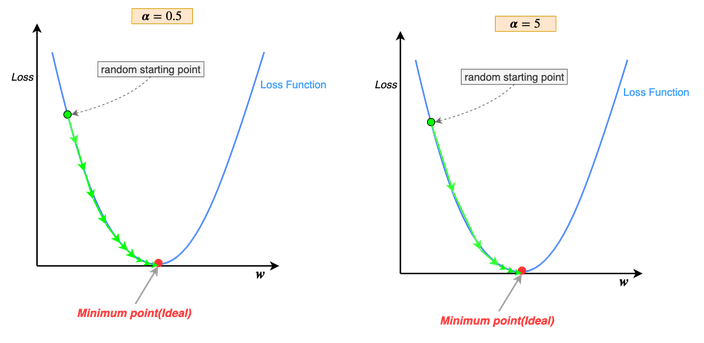

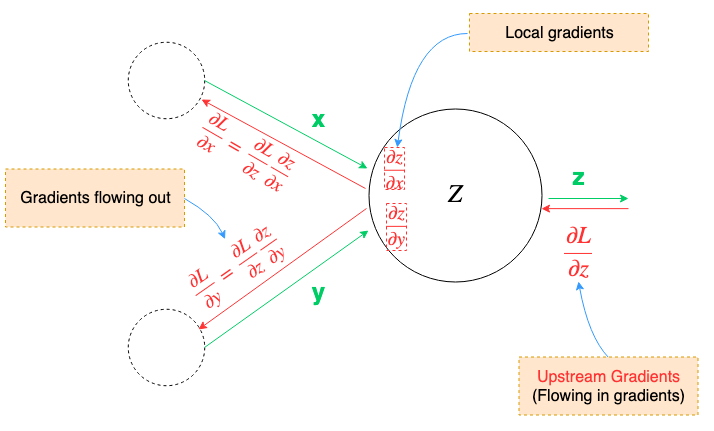

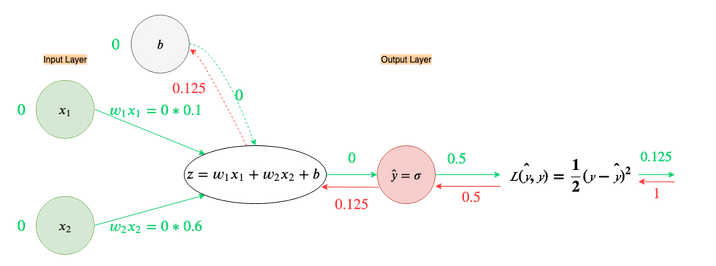

## Multiple neurons

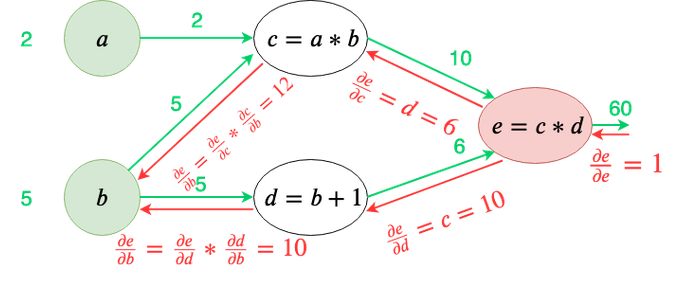

# Layers

*How to make NN more powerful?* 
- Model: $h(x) = w^T\phi(x) + b$
- $\phi(x) = \sigma(Ax + c)$

*Idea 1* 
- Make $A$ bigger -> Fat layers

*Idea 2* 
- $\phi(x) = \sigma(A\phi'(x) + c)$
- $\phi'(x) = \sigma(A\phi''(x) + c)$
- $\phi''(x) = \sigma(Ax + c)$

**Remarks**
- *Idea 2* wasn't done in the past because matrix multiplication was expensive
- **Theoretically**: We can prove that *Idea 2* will always be worse than *Idea 1*
- **Practically**: But in practice we see that the computational power and power of will win in the end

BUT
- The layers take into account what the previous layers already learnt => Exponential growth in learning power
- So for *Idea 1* to work the matrix $A$ would have to grow exponentially in size
- *Idea 2* has small matrices that can learn much more

## Hidden layers

In [ ]:
class Layer:
    '''
    Abstract layer class.
    '''

    def __init__(self, *args, **kwargs):
        raise NotImplementedError()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError()

        
    def backward(self, *args, **kwargs):
        raise NotImplementedError()

    def update_params(self, *args, **kwargs):
        pass

In [ ]:
class LinearLayer(Layer):
    """
    LinearLayer: Performs affine transformation of input.
    """

    def __init__(self, n_in, n_out):
        """
        Constructor of the linear layer.
        Arguments:
            - n_in {int} -- Number (or dimension) of inputs.
            - n_out {int} -- Number (or dimension) of outputs.
        """
        self.n_in = n_in
        self.n_out = n_out

        self._W = initialize_weights(n_in, n_out)
        self._b = np.zeros((1, n_out))

        self._cache_current = None
        self._grad_W_current = None
        self._grad_b_current = None

    def forward(self, x):
        """
        Performs forward pass through the layer (i.e. returns Wx + b).
        Logs information needed to compute gradient at a later stage in
        `_cache_current`.
        Arguments:
            x {np.ndarray} -- Input array of shape (batch_size, n_in).
        Returns:
            {np.ndarray} -- Output array of shape (batch_size, n_out)
        """
        self._cache_current = {"x": x} # Store input
        
        ## Code here
        ### We propagate the value that we want to return here
        
        return z

    def backward(self, grad_z):
        """
        Given `grad_z`, the gradient of some scalar (e.g. loss) with respect to
        the output of this layer, performs back pass through the layer (i.e.
        computes gradients of loss with respect to parameters of layer and
        inputs of layer).
        Arguments:
            grad_z {np.ndarray} -- Gradient array of shape (batch_size, n_out).
        Returns:
            {np.ndarray} -- Array containing gradient with respect to layer
                input, of shape (batch_size, n_in).
        """
        x = self._cache_current["x"]
        self._grad_W_current = x.T.dot(grad_z) 
        self._grad_b_current = np.ones(len(x)).dot(grad_z)
        
        return grad_z.dot(self._W.T)

    def update_params(self, learning_rate):
        """
        Performs one step of gradient descent with given learning rate on the
        layer's parameters using currently stored gradients.
        Arguments:
            learning_rate {float} -- Learning rate of update step.
        """
        
        # Code here
        

## Functional layers / Activation functions

https://arxiv.org/ftp/arxiv/papers/2010/2010.09458.pdf

### Sigmoid

Sigmoid function:
- $\sigma(x) = \dfrac 1  {1 + e^{-x}}$

Sigmoid derivative:
- $\sigma(x)' = \sigma(x) (1 - \sigma(x))$
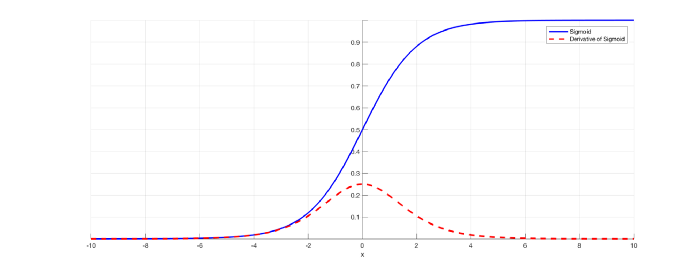

In [ ]:
def sigmoid(x, derivative = False):
    '''
    Arguments
        x: ndarray / value -- the value to calculate sigmoid on
        derivative: bool -- if we want the derivative or not
    Return:
        ndarray / value -- the derivative
    '''
    if derivative:
        ## Code here
        
        return  s_
    ## Code here
    
    return s

In [ ]:
x = np.linspace(-6, 6, 100)
plt.figure(figsize = (10, 6))
plt.plot(sigmoid(x))
plt.plot(sigmoid(x, derivative=True))
plt.legend(['sigmoid', 'sigmoid derivative'])

In [ ]:
class SigmoidLayer(Layer):
    """
    SigmoidLayer: Applies sigmoid function elementwise.
    """

    def __init__(self):
        self._cache_current = None # stored information to compute gradient 

    def forward(self, x):
        """
        Arguments:
            x {np.ndarray} -- Input array of shape (batch_size, n_in).
        Returns:
            {np.ndarray} -- Output array of shape (batch_size, n_out)
        """
        self._cache_current = {"x": x}
        # Code here
        
        return s

    
    def backward(self, grad_z):
        """
        Given `grad_z`, the gradient of some scalar (e.g. loss) with respect to
        the output of this layer, performs back pass through the layer (i.e.
        computes gradients of loss with respect to parameters of layer and
        inputs of layer).
        Arguments:
            grad_z {np.ndarray} -- Gradient array of shape (batch_size, n_out).
        Returns:
            {np.ndarray} -- Array containing gradient with respect to layer
                input, of shape (batch_size, n_in).
        """
        
        x = self._cache_current["x"]
        
        ## Code here
        
        return grad

### Softmax (not tested yet)

In [ ]:
# Softmax
# http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/

class SoftmaxLayer(Layer):
    """
    SigmoidLayer: Applies sigmoid function elementwise.
    """

    def __init__(self):
        self._cache_current = None # stored information to compute gradient 

    def forward(self, x):
        """
        Arguments:
            x {np.ndarray} -- Input array of shape (batch_size, n_in).
        Returns:
            {np.ndarray} -- Output array of shape (batch_size, n_out)
        """
        self._cache_current = {"x": x}
        return softmax(x)

    
    def backward(self, grad_z):
        """
        Given `grad_z`, the gradient of some scalar (e.g. loss) with respect to
        the output of this layer, performs back pass through the layer (i.e.
        computes gradients of loss with respect to parameters of layer and
        inputs of layer).
        Arguments:
            grad_z {np.ndarray} -- Gradient array of shape (batch_size, n_out).
        Returns:
            {np.ndarray} -- Array containing gradient with respect to layer
                input, of shape (batch_size, n_in).
        """
        x = self._cache_current["x"]
        #grad_z = np.reshape(grad_z, (1, -1))
        J = softmax(x, derivative=True) 
        J = J.sum(axis = 1) # sum across rows for each sample
        #print(x.shape, J.shape, grad_z.shape)
        grad = np.multiply(J, grad_z)
        return grad

### ReLU

**Relu function**
- $f(x) = \max(x, 0)$

**Relu derivative**
- $f'(x) = 1 \text{ if } x > 0 \text{ else } 0$

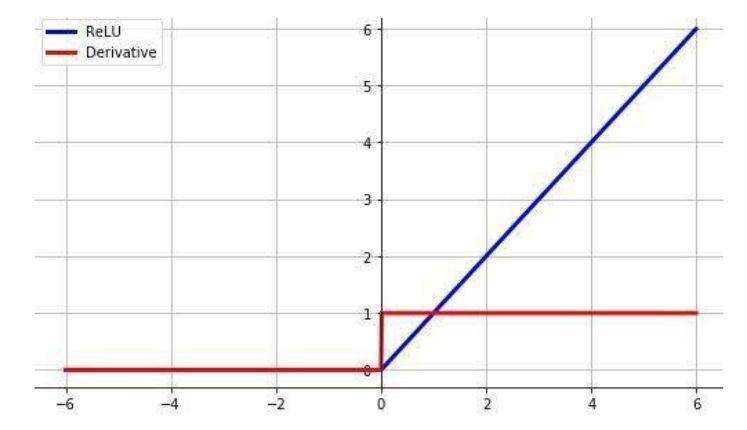

In [ ]:
def relu(x, derivative = False):
    '''
    Arguments
        x: ndarray / value -- the value to calculate ReLU on
        derivative: bool -- if we want the derivative or not
    Return:
        ndarray / value -- the derivative
    '''
    
    if derivative:
        ## Code here
        return r_
    ## Code here
    return r

In [ ]:
x = np.linspace(-4, 4, 100)
plt.figure(figsize = (10, 6))
plt.plot(relu(x))
plt.plot(relu(x, derivative=True))
plt.legend(['relu', 'relu derivative'])

In [ ]:
class ReLULayer(Layer):
    """
    ReluLayer: Applies Relu function elementwise.
    """

    def __init__(self):
        self._cache_current = None

        
    def forward(self, x):
        """
        Performs forward pass through the ReLU layer.
        Logs information needed to compute gradient at a later stage in
        `_cache_current`.
        Arguments:
            x {np.ndarray} -- Input array of shape (batch_size, n_in).
        Returns:
            {np.ndarray} -- Output array of shape (batch_size, n_out)
        """
        self._cache_current = {"x": x}
        ## Code here
        
        return r


    def backward(self, grad_z):
        """
        Given `grad_z`, the gradient of some scalar (e.g. loss) with respect to
        the output of this layer, performs back pass through the layer (i.e.
        computes gradients of loss with respect to parameters of layer and
        inputs of layer).
        Arguments:
            grad_z {np.ndarray} -- Gradient array of shape (batch_size, n_out).
        Returns:
            {np.ndarray} -- Array containing gradient with respect to layer
                input, of shape (batch_size, n_in).
        """
        x = self._cache_current["x"]
        ## Code here
        
        return grad


# Model

## Model class

In [ ]:
class MultiLayerNetwork:
    """
    MultiLayerNetwork: A network consisting of stacked linear layers and
    activation functions.
    """

    def __init__(self):
        """
        Constructor of the multi layer network.
        Arguments:
            - input_dim {int} -- Number of features in the input (excluding
                the batch dimension).
        """
        self._layers = []

        
    def __call__(self, x):
        return self.forward(x)
    
    
    def add(self, layer):
        '''
        Add layer to the layer list
        Arguments:
            layer: Layer -- layer to add
        '''
        ## Code here
        

    
    def forward(self, x):
        """
        Performs forward pass through the network.
        Arguments:
            x {np.ndarray} -- Input array of shape (batch_size, input_dim).
        Returns:
            {np.ndarray} -- Output array of shape (batch_size,
                #_neurons_in_final_layer)
        """
        ## Code here
        
        return output


    
    def backward(self, grad_z):
        """
        Performs backward pass through the network.
        Arguments:
            grad_z {np.ndarray} -- Gradient array of shape (1,
                #_neurons_in_final_layer).
        Returns:
            {np.ndarray} -- Array containing gradient with respect to layer
                input, of shape (batch_size, input_dim).
        """
        ## Code here
            
        return grad
    

    def update_params(self, learning_rate):
        """
        Performs one step of gradient descent with given learning rate on the
        parameters of all layers using currently stored gradients.
        Arguments:
            learning_rate {float} -- Learning rate of update step.
        """
        
        ## Code here
        

## Get data

### Digits

In [ ]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


In [ ]:
#X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
## Read and preprocess data
data= load_digits()
X_, y_ = data['data'], data['target']


In [ ]:
idx = 0
print(f"Label: {y[idx]}")
plt.imshow(X[idx].reshape(8, 8), cmap = 'gray')

In [ ]:
enc = OneHotEncoder()
y = enc.fit_transform(y[:, np.newaxis]).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=420)
X_train.shape, X_test.shape, 

In [ ]:
G = 8
X_sel = X_train[:G * G]
plt.figure(figsize = (10, 10))
plt.imshow(np.concatenate(X_sel.reshape(G, 8 * G, 8), axis = 1))

### Mnist

In [ ]:
import pandas as pd

df_train =  pd.read_csv('mnist/mnist_train.csv')
df_test =  pd.read_csv('mnist/mnist_test.csv')

In [ ]:
X_train, y_train = df_train.drop('label', axis = 1).to_numpy(), df_train['label'].to_numpy()
X_test, y_test = df_test.drop('label', axis = 1).to_numpy(), df_test['label'].to_numpy()
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train.shape, X_test.shape

In [ ]:
plt.imshow(X_train[0].reshape(28, 28)), y_train[0]

In [ ]:
G = 16
X_sel = X_train[:G * G]
plt.figure(figsize = (10, 10))
plt.imshow(np.concatenate(X_sel.reshape(G, 28 * G, 28), axis = 1))

In [ ]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train[:, np.newaxis]).toarray()
y_test = enc.fit_transform(y_test[:, np.newaxis]).toarray()

## Init model

In [ ]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

# Create a model with 2 Linear layers and a ReLU

In [ ]:
# Check untrained accuracy

y_pred = model(X_train)
accuracy(np.argmax(y_train, axis = 1), np.argmax(y_pred, axis = 1))

## Training loop

### Train on all data

In [ ]:
from tqdm import trange

In [ ]:
losses = []
accuracies = []
# Training params
epochs = 100
lr = .1
batch_size = 32
for epoch in (t := trange(epochs)):
    
    # Shuffle dataset each epoch
    X_train_sh, y_train_sh = shuffle(X_train, y_train) 
    # Get batches
    X_batches, y_batches = get_batches(X_train_sh, batch_size), get_batches(y_train_sh, batch_size)
    loss = 0.
    acc = 0.
    for X_batch, y_batch in zip(X_batches, y_batches):
        ## Code here
        ### Get predictions
        
        ### Calculate loss and accuracy to plot later
        
        ### Calculate loss gradient
        
        ### Backpropagate
        
        ### Update parameters
        
        ## Stop coding here
        
    
    acc /= len(X_batches)
    loss /= len(X_batches)
    accuracies.append(acc)
    losses.append(loss)
    t.set_description(f"loss: {round(loss, 2)}, accuracy: {round(acc, 2)}")

In [ ]:
y_pred = model(X_train)
print(f"Accuracy on train: {accuracy(np.argmax(y_train, axis = 1), np.argmax(y_pred, axis = 1))}")

y_pred = model(X_test)
print(f"Acccuracy on test: {accuracy(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))}")

In [ ]:
#plt.figure(figsize = (10,10))
fig, axs = plt.subplots(1, 2, figsize = (30, 6))

axs[0].plot(losses)
axs[1].plot(accuracies)

# Optimizers

# Resources

Weight initialization
- https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
- https://www.youtube.com/watch?v=kPXxbmBsFxs&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=35